# Overview

Fix a graph $\Gamma$ and recall the definition of a $\phi$-stability condition as given in Section $2.2$ of the thesis.

Here we state a method which given $\phi \in V^{d}(\Gamma)$ returns $\sigma_{\Gamma}^{\phi} \in \Sigma_{\Gamma}^{d}$ (provided $\phi$ is non-degenerate). In particular this method return $A_{\Gamma}:=\sigma_{\Gamma}^{\phi}|_{\mathcal{ST(\Gamma)}}$ and $\sigma_{\Gamma}^{\phi}(\Gamma)$. 

## Method outline

Given $\phi$ we use the definition of $\phi$-stability conditions to define $\vec{d} \in \Sigma_{\Gamma}^{\phi}(T)$ for each $T \in \mathcal{ST}(\Gamma)$. Let $\Gamma^{'}$ be a elementary induced subgraph of $\Gamma$. We do this by:

1) First computing all the components to define the upper and lower bound for $\vec{d}_{\Gamma^{'}}$ as stated in the definition of $\phi$-stability condition in the case of a tree $T$ and $\Gamma^{'}$.

2) We 

- Given $\phi$ get bounds for $\sum_{I} d_I$ where $I$ is given by the set of vertices for complete subgraphs used above.
- Change upper and lower
- Store as a dictionary of form: dic = {"1":[0,1,3], "2":[0,-1], "12":[0,4]}
- Pass dictionary to solver to get unique $\vec{d}$

# Table of contents


In [ ]:
1. [Functions](#s1)
    1. [Cyclic graphs: genus 1](#s11)
    2. [Genus 2 graphs with middle edges](#s12)
2. [Examples](#s2)

# Functions

## Used throughout

In [1]:
import numpy as np
import itertools
import pickle
from fractions import Fraction
from collections import Counter
import textwrap

## Get $\sigma_{\Gamma}^{\phi}(\Gamma)$

We take the assignment induced datum $\sigma_{\Gamma}^{A_{\Gamma}}$ for a given $A_{\Gamma}$. See "1_Assignment_induced_datum.ipynb" for the description of the following functions

In [2]:
# Assignment_datum_for_G for w_stability:
def get_sp_trees(G): #Out: list of edges in spanning tree
    all_trees=[]
    for g in list(G.spanning_trees()):
        all_trees.append(g.edges(sort=True, labels=False))
    return all_trees
def list_difference(a, b):
    "https://stackoverflow.com/questions/8106227/difference-between-two-lists-with-duplicates-in-python"
    count = Counter(a) # count items in a
    count.subtract(b)  # subtract items that are in b
    diff = []
    for x in a:
        if count[x] > 0:
           count[x] -= 1
           diff.append(x)
    return diff

def chip_adding(graph_t,tree,ass):
    """
    Inputs:
    graph: G_edges graph edges
    tree : spanning tree of graph
    ass : an n=vert(graph) tuple on the spanning tree.
    
    recursion idea: https://stackoverflow.com/questions/53638816/python-library-function-to-re-apply-a-function-to-its-own-output-until-output-re
    """
    
    edges=graph_t # just want the edges 
    
#     print("Gp edges",graph_t)
#     print("tree edges",tree)
    
    n=len(ass)
    complement=list_difference(graph_t,tree) #edges in complement.
    
    def rec_funct(edge_l,inputs,n):
        data=[]
        edge=edge_l[0]
        
        for b in inputs:
            delta_1=np.zeros(n)
            delta_2=np.zeros(n)
            
            delta_1[int(edge[0])]=1 #we chip add at the first vertex. #### <- CHANGED as taking vertices 0,..,n-1 now
            delta_2[int(edge[1])]=1 #we chip add at the second vertex.
            
            b1=b+delta_1
            b2=b+delta_2
            data=data+[b1,b2]
        
        return (edge_l,data,n)
    
    def recursion(edge_l,inputs,n):
        
        new_data=rec_funct(edge_l,inputs,n)
        edge_l=edge_l[1:] #removeing first edge        
        new_data=(edge_l,new_data[1],new_data[2])
                
        if len(edge_l)==0:
            new_inputs=new_data[1]
            return new_inputs
        else:
            return recursion(*new_data)
        
    breaks=recursion(complement,[np.zeros(n)],n)
    breaks=np.unique(breaks, axis=0)
    
    patch=[]
    for bbreak in breaks:
        patch.append(ass+bbreak)
    
    return patch

def w_stability(graph,Assignments):
    
    """
    #Graphs are labelled v0 to v_n-1
    Inputs:
        graph: Any smallish finite multigraph
        Assignments: A list of (complexity of graph many) lists of length vert(graph).
    
    Outputs: a list of lists of length vert(graph) corresponding to liine bundle multidegrees obtained by chip adding.

    """
    G=graph
    
    G_edges=G.edges(sort=True, labels=False)
    tree_l=get_sp_trees(G)

    lbm_patches=[] # the set of patches,which we'll take the union of. 
    for index,tree in enumerate(tree_l):    
        ass=Assignments[index]    
        patch=chip_adding(G_edges,tree,ass)  
        
#         print("Patch",[x.astype(int).tolist() for x in patch],"\n") #If want to see patches of lbm.
        
        lbm_patches.append(patch)
    
    sig=np.concatenate(lbm_patches, axis=0)
    
    sig=sig.astype('int32')
    
#     print(np.array(sig))
    sig=np.unique(sig, axis=0)
    
    return sig

def check_size(G,sigma):
#     print("len(get_sp_trees(G))",len(get_sp_trees(G)))
#     print("len(sigma)",len(sigma))
    if len(sigma)==len(get_sp_trees(G)):
        x="This choice of assignments -- gives -- a stability condition."
        y=True
    else: 
        x="This choice of assignments -- not give -- a stability condition."
        y= False 
    return y,x

## Get components to define $\sigma_{\Gamma}^{\phi}$

We now state the function to obtain all the components to define the upper and lower bound for $\vec{d}_{\Gamma^{'}}. See "5_phi_analysis" for a description of the following functions.

In [3]:
def get_pairs_con_subg(G):# for phi_tree_inequalities_data
    
    """
    Note: we are not working with multigraphs so connected_subgraph_iterator should give subgraphs with all edges between
    
    If Issue may be HERE due to this. 
    
    Objective: Used to get cut info and total degree adjustment
    Input:
    Return: Pairs of complete subgraphs for V and V^{c} such that V scup V^{c}=V(G)
    """
    
    vert_G=G.vertices()
    edges_G=G.edges()
    
    #get list of connected subgraphs:
    
    #Want to get pairs of complete subgraphs for pairs of vertices that is a is disjoint union of all verts
    ll=list(G.connected_subgraph_iterator())

    # put them into pairs, where vertices are a disjoint union of G.
    pairs=[]
    for i in ll:
        a=i.vertices()
        for j in ll:
            b=j.vertices()
            if sorted(a+b)==vert_G:
                #May need to take complete graph here containing a, and for b. 
                pairs.append((i,j))
                
#                 """
#                 We only need one subgraph in the cut, the following step prevents us having both subg in a cut.
#                 """
#                 if (i,j) in pairs:
#                     continue
#                 if (j,i) in pairs:
#                     continue
#                 else:
#                     pairs.append((i,j))
                    
#     for i in get_pairs_con_subg(G):
#         print(i[0].vertices(),i[1].vertices())
    return pairs

def get_cut_edges(G,pair): #for phi_tree_inequalities_data
    
    """
    Obj:Get list of the edges in a cut for a given pair, 
    for a pair of connected subgraphs that partitions the vertices of G.
    
    Return: list of edges in cut for a pair of connected subgraphs that partition the vertices of G 
    """
    a_edges=pair[0].edges()
    b_edges=pair[1].edges()
    total_edges=a_edges+b_edges
    
    edges_G=G.edges()

    #Cut edges.
    cut_edges=[ e for e in edges_G if e not in total_edges]
    
    return cut_edges

def edges_cut_inandnotin_tree(cut_edges,tree):#Used in phi_tree_inequalities_data
    
    """
    
    Obj: Consider cut_edges_G and ask if any of the edges of T are in cut_edges_G

    Returns: Number of edges in tree, and not in tree
    """

    tree_edges=tree.edges()

    e_in_tree=[edge for edge in cut_edges if edge in tree_edges]
    # print("edges of cut that belong to tree:",tree_edges_cut)

    e_notin_tree=[edge for edge in cut_edges if edge not in tree_edges]
    # print("edges of cut that do not belong to tree:",tree_comp_edges_cut)
    
    num_e_in_tree ,num_e_notin_tree=len(e_in_tree),len(e_notin_tree)
    
    return num_e_in_tree ,num_e_notin_tree

def get_gamma0_missing_edges(G,T,complete_subg):
    """
    Objective:find adjustment to degree of divisors, a number, to correct to the total degree.
    given by the number of edges in complete subgrahp which are not in gamm0
    Input: gamma0 (the tree), and the complete_subg
    Return: number of edges complete_subg has over T (on one side of the  cut).
    
    
    Want |E(gamma0^c) cap E(gamma')| where gamma' is the complete subgraph and gamma0 the connected spanning subg.
    """
    
    
    gamma0_complement=[e for e in G.edges() if e not in T.edges()]
    
    gamma0_comp_inter_complete_subg=[e for e in gamma0_complement if e in complete_subg.edges()]
    
    return len(gamma0_comp_inter_complete_subg)

def phi_tree_inequalities_data(G,T): #Main
    
    """
    Objective: Used in tree_poly
    Inputs: 
    G: graph
    T:graph of spanning tree (or any spanning connected subgraph)
    
    Return:dictionary of data used to define the phi-tree inequalties. 
    Returns phi_G

    Dict contains the vertices of the cut : key
    List of [e_in_tree ,e_notin_tree]: value
    
    Where num_e_in_tree = edges of cut the belong to tree
         ,num_e_notin_tree= edges of cut that do not belong to tree
         
    terms=[num_e_in_tree ,num_e_notin_tree,gamma0_missing_edges]

    """
    
    #for main

    pairs=get_pairs_con_subg(G)

    inequ_data=[]
    for pair in pairs: 
        
        #As only care about one complete subg, we get the number of missing edges of T and complete_subg.
        complete_subg=pair[0]
        gamma0_missing_edges=get_gamma0_missing_edges(G,T,complete_subg)
        
        
        #Would like to know the edges that G has in the cut. i.e. cut_edges_G
        cut_edges=get_cut_edges(G,pair)

        num_e_in_tree ,num_e_notin_tree=edges_cut_inandnotin_tree(cut_edges,T)

        terms=[num_e_in_tree ,num_e_notin_tree,gamma0_missing_edges]
        
#         print("pair[0].vertices():",pair[0].vertices(),"pair[1].vertices():",pair[1].vertices())
#         print("[num_e_in_tree ,num_e_notin_tree]",terms)


        "Do we need to add the data for both subg in pair?"

        #get vertices of subg in pair and turn to "v1v2v3" format.
        subg1_l=pair[0].vertices()
        subg1 = ''.join(subg1_l)
        inequ_data.append((subg1,terms)) #subg1 is the indexor in phi_tree_formatted_hyperplanes

#         print("(subg1,terms):",(subg1,terms))
#         subg2_l=pair[1].vertices()
#         subg2 = ''.join(subg2_l)
#         inequ_data.append((subg2,terms))


    #Now join to phi-inequal data dict
    phi_tree_iequal_dict = {t[0]: t[1] for t in inequ_data}

    return phi_tree_iequal_dict

def sum_comps(comp,indexor): #Done
    """returns the sum of the components of comp in the position by indexor"""
    #for d and phi
    sum_l=[comp[int(i)] for i in indexor] #Becuase of the vertex labeling of G having v_0....
    return sum(sum_l)

## Functions are specific to this notebook.

We modify the functions lower-part, upper-part, phi-tree-formatted-hyperplanes stated in "5_phi_analysis" (which worked to find a $\phi$) to the context where the target is $\vec{d}$.

In [4]:
def get_lower_threshold(indexor,phi,num_e_in_tree,num_e_notin_tree,gamma0_missing_edges):
    
    """
    Objective: get lower constant bounding sum d_i
    Input:
    Returns: constant
    """

    #get b term
    T_term=num_e_in_tree*0.5
    T_comp_term=num_e_notin_tree*0.5
    phi_comp_sum=sum_comps(phi,indexor)
    
    B= T_comp_term+gamma0_missing_edges-phi_comp_sum
    
    lower_term=-T_term - B #See phi_tree_inequality_doc
    
        
    return lower_term

def get_upper_threshold(indexor,phi,num_e_in_tree,num_e_notin_tree,gamma0_missing_edges):
    
    """
    Objective: Get upper constant
    Input:
    Returns:constant
    """

    #get b term
    T_term=num_e_in_tree*0.5
    T_comp_term=num_e_notin_tree*0.5
    phi_comp_sum=sum_comps(phi,indexor)
    
    B= T_comp_term+gamma0_missing_edges-phi_comp_sum
    
    upper_term=T_term - B #See phi_tree_inequality_doc
    
        
    return upper_term

The next function is a modification of the function phi-tree-formatted-hyperplanes() (determining the bounds for for  $d_{\Gamma^{'}}$ for each $\Gamma^{'}$).

In [5]:
def divisor_bounds(G,phi_G, phi,int_range=10):
    
    """
        Obj: Returns bounds on elements of vec{d} and the relations to be passed to solve to find the unique assignment on T.   
        Get the ranges for d_i +...+d_j where i ranges over complete subg of cut.

        Inputs:
        int_range:Simulates the integers increase size if fails.
        phi_G =  A dictionary that records indexs of cuts as keys, and value=[num_e_in_tree,num_e_notin_tree]
    
        Returns: a dictionary of the form dic = {"1":[1], "2":[0],"3":[0],"12":[1],"13":[1],"23":[0]}
        
    """
    
    # Generate a list of integers from 1 to 200
    integers = range(-int_range-1, int_range+1)
    
    S=[] #Stored (key,values)

    
    #Add the sum to zero requirement: 
    #length of phi:
    n=len(phi)
    s = "".join([str(i) for i in range(n)])
    # # We add the total degree equation to inequals for phi
    # deg=0 #will be 0 for trees.
    # tot_equ1=[-deg,]+ [1]*n
    # tot_equ2=[deg,]+ [-1]*n
    S.append((s,0))
        
    for indexor in list(phi_G.keys()):

        num_e_in_tree,num_e_notin_tree,gamma0_missing_edges=phi_G[indexor] #value=[num_e_in_tree,num_e_notin_tree]    

        upper_threshold=get_upper_threshold(indexor,phi,num_e_in_tree,num_e_notin_tree,gamma0_missing_edges)

        lower_threshold=get_lower_threshold(indexor,phi,num_e_in_tree,num_e_notin_tree,gamma0_missing_edges)

        # Use a list comprehension to filter out integers above the threshold
        integers_between_threshold = [x for x in integers if upper_threshold>x > lower_threshold]

        
        S.append((indexor,integers_between_threshold))


     #Turn S into dictionary.  
    dic=dict(S)
        
    return dic

Finally solver() returns $\vec{d} \in \sigma_{\Gamma}(T)$ from the range of values of $\vec{d}_{\Gamma^{'}}$ for each
for each $\Gamma^{'}$.

In [6]:
def solver(dic):
    """
    Objective: get \vec{d} ass on trees from range of values of d_i and relations.
    Input:dictionary for all values of vec{d} with relations which will determine d_i for singlton i.
    Returns: vec{d} main
    """
    
    # Extract the values of d1 to d6 from the input dictionary
    d_values = [dic[key] for key in sorted(dic.keys()) if len(key) == 1]

    # Extract the sets of sums from the input dictionary
    sum_sets = {}
    for key in dic.keys():
        if len(key) >1:
            value = dic[key]
            if isinstance(value, (list, tuple)):
                sum_sets[key] = set(value)
            else:
                sum_sets[key] = set([value])
#     print("sum_sets",sum_sets)

    # Initialize a list to store the values of d1 to d6 that satisfy the conditions
    solutions = []

    # Iterate through all possible combinations of d1 to d6
    for d in itertools.product(*d_values):
        
#         print(d)
        
        # Check if all sums are in their respective sets
        valid = True
        for key, s in sum_sets.items():
            indices = [int(i) for i in key]
            if sum([d[i] for i in indices]) not in s:
#                 print("key",key,"s",s)
                
                valid = False
                break
        # If all sums are valid, add the solution
        if valid:
            solutions.append(d)

    # Print the solutions
    if len(solutions) == 0:
        print(False,"No solutions found")
        return False,"No solutions found"
    if len(solutions) >1 :
        return False,"More than one solution found"
    else: #1 solution found
        
#         for d in solutions:
#             print(" ".join([f"d{i} = {d[i-1]}" for i in range(1, len(d_values)+1)]))
        [d_tuple]=solutions
        return list(d_tuple),"Exactly one divisor"

def get_assignment_phi(G,T,phi):
    
    """
    Objective: by checking inequalities gt unique d_i components for vec{d}.
    Input:
    Returns: unique assignment divisor
    """
    
    #get data for inequalities for divisor_bounds
    phi_G=phi_tree_inequalities_data(G,T)
    
    # bounds for vec{d}
    dic=divisor_bounds(G,phi_G, phi,int_range=10)
#     print(dic)
    
    
    #Get divisor satisfying equations of dic
    divisor=solver(dic)[0]
    
    return divisor

The next function applies get_assignment_phi to each tree

In [7]:
def get_all_assignment_phi(phi,G):

    """
    Objective: Given a phi gets the tree assignment
    Input:
    Returns: list of assignments for all trees i.e [(T,ass) for each T in G]
    """
    spanning_trees=[tree for tree in G.spanning_trees(labels=true)] #incase have GM1 double edge graph

    ass_l=[]
    for T in spanning_trees:
        
        #Get unique assignment on tre
        ass=get_assignment_phi(G,T,phi)
        
        #record
        ass_l.append((T,ass))
    
    return ass_l

# Examples

## $3$-necklace

Let $\Gamma$ by the $3$-necklace graph.

In [44]:
# graphname="G3"
G=Graph([("0","1"),("1","2"),("2","0")], multiedges=True)
spanning_trees=[tree for tree in G.spanning_trees()]
# plot(G, figsize=3)

### Trivial stability condition

In [49]:
#known weak stability condition.
# assignments=[(spanning_trees[0],[0,0,0]),(spanning_trees[1],[0,0,0]),(spanning_trees[2],[0,0,0])]
Assignments=[[0,0,0],[0,0,0],[0,0,0]]
w_stability(G,Assignments)

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=int32)

Note that the assignments as list of integers need to be in the same ordering as the spanning trees graphs of G given by list(G.spanning_trees())

Given a $\phi$ we obtain $A_{\Gamma}$

In [9]:
phi=(0.3,0.3,0.3)

In [48]:
ass_1=get_assignment_phi(G,spanning_trees[0],phi)
ass_2=get_assignment_phi(G,spanning_trees[1],phi)
ass_3=get_assignment_phi(G,spanning_trees[2],phi)
print(ass_1,ass_2,ass_3) #[0, 0, 0],[0, 0, 0],[0, 0, 0]

[0, 0, 0] [0, 0, 0] [0, 0, 0]


Let us now take the chip-adding saturation and see that $A_{\Gamma}$ give a $\phi$-stability condition.

In [46]:
# assignments=[(spanning_trees[0],ass_1),(spanning_trees[1],ass_2),(spanning_trees[2],ass_3)]
assignments=[ass_1,ass_2,ass_3]

In [47]:
w_stability(G,assignments)

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=int32)

### Non-trivial stability condition

In [12]:
#known weak stability condition.
# assignments=[(spanning_trees[0],[0,0,0]),(spanning_trees[1],[0,1,-1]),(spanning_trees[2],[1,0,-1])]
Assignments=[[0,0,0],[0,1,-1],[1,0,-1]]
# w_stability(G,assignments)

Given a $\phi$ we obtain $A_{\Gamma}$

In [9]:
phi=(0.6,0.6,-0.3)

In [ ]:
ass_1=get_assignment_phi(G,spanning_trees[0],phi)
ass_2=get_assignment_phi(G,spanning_trees[1],phi)
ass_3=get_assignment_phi(G,spanning_trees[2],phi)

print(ass_1,ass_2,ass_3) #[0, 0, 0],[0, 0, 0],[0, 0, 0]

Let us now take the chip-adding saturation and see that $A_{\Gamma}$ give a $\phi$-stability condition.

In [ ]:
assignments=[(spanning_trees[0],ass_1),(spanning_trees[1],ass_2),(spanning_trees[2],ass_3)]
assignments=[ass_1,ass_2,ass_3]

In [ ]:
w_stability(G,assignments)

## Larger example

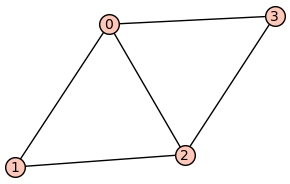

In [76]:
graphname="G4M2"
E=[('0', '1'), ('0', '2'), ('0', '3'), ('1', '2'), ('2', '3')] 
G=Graph(E, multiedges=True)
spanning_trees=[tree for tree in G.spanning_trees()] #8
plot(G, figsize=3)

Let have $d=b_{1}(\Gamma)=2$ here

In [ ]:
#break divisor case:
# phi=(0.75, 0.25, 0.75,0.25)

#work
phi=( 1.25, 0.5, 0.75,-0.5)

phi=(0.75,0.5, 1.25, -0.5)

phi=(0.25, 0.75, 0.25, 0.75)

In [131]:
ass_1=get_assignment_phi(G,spanning_trees[0],phi)
ass_2=get_assignment_phi(G,spanning_trees[1],phi)
ass_3=get_assignment_phi(G,spanning_trees[2],phi)
ass_4=get_assignment_phi(G,spanning_trees[3],phi)
ass_5=get_assignment_phi(G,spanning_trees[4],phi)
ass_6=get_assignment_phi(G,spanning_trees[5],phi)
ass_7=get_assignment_phi(G,spanning_trees[6],phi)
ass_8=get_assignment_phi(G,spanning_trees[7],phi)

print(ass_1,ass_2,ass_3,ass_4,ass_5,ass_6,ass_7,ass_8) #[0, 0, 0],[0, 0, 0],[0, 0, 0]

False No solutions found
False No solutions found
False No solutions found
False No solutions found
False No solutions found
False No solutions found
False No solutions found
False No solutions found
False False False False False False False False


In [111]:
assignments=[ass_1,ass_2,ass_3,ass_4,ass_5,ass_6,ass_7,ass_8]
w_stability(G,assignments)

array([[ 0,  0,  2,  0],
       [ 0,  1,  1,  0],
       [ 0,  1,  2, -1],
       [ 1,  0,  1,  0],
       [ 1,  0,  2, -1],
       [ 1,  1,  0,  0],
       [ 1,  1,  1, -1],
       [ 2,  0,  1, -1]], dtype=int32)

## G4M2 results we know 

In [ ]:
#There is some rotation in the phi below so not exactly correct for above.

Graph G:
[('0', '1', 'e1'), ('0', '2', 'e0'), ('0', '3', 'e4'), ('1', '2', 'e2'), ('2', '3', 'e3')] 

-----------------------------------------

Cycle: (1, 3, 4, 2)


Assignment: (tree,assignment)
(1, array([0., 0., 0., 0.]))
(2, array([ 1.,  0., -1.,  0.]))
(3, array([ 0.,  1., -1.,  0.]))
(4, array([ 0.,  1., -1.,  0.]))
(5, array([ 0.,  1., -1.,  0.]))
(6, array([ 0.,  1., -1.,  0.]))
(7, array([ 0.,  1., -1.,  0.]))
(8, array([ 0.,  0., -1.,  1.]))


Line bundle multidegrees:
[ 0.  1. -1.  2.]
[0. 1. 0. 1.]
[ 0.  2. -1.  1.]
[0. 2. 0. 0.]
[1. 0. 0. 1.]
[ 1.  1. -1.  1.]
[1. 1. 0. 0.]
[ 1.  2. -1.  0.]

The phi (center of polytope): (0.5, 1.25, -0.5, 0.75) does not fail the phi-inequalities
phi average is: [ 0.5   1.25 -0.5   0.75]

----------------------------------------- 

Cycle: (1, 2, 3, 4)


Assignment: (tree,assignment)
(1, array([0., 0., 0., 0.]))
(2, array([0., 0., 0., 0.]))
(3, array([0., 0., 0., 0.]))
(4, array([0., 0., 0., 0.]))
(5, array([0., 0., 0., 0.]))
(6, array([0., 0., 0., 0.]))
(7, array([0., 0., 0., 0.]))
(8, array([0., 0., 0., 0.]))


Line bundle multidegrees:
[0. 0. 0. 2.]
[0. 0. 1. 1.]
[0. 1. 0. 1.]
[0. 1. 1. 0.]
[0. 2. 0. 0.]
[1. 0. 0. 1.]
[1. 0. 1. 0.]
[1. 1. 0. 0.]

The phi (center of polytope): (0.25, 0.75, 0.25, 0.75) does not fail the phi-inequalities
phi average is: [0.375 0.625 0.375 0.625]


----------------------------------------- 

Cycle: (1, 2, 4, 3)


Assignment: (tree,assignment)
(1, array([0., 0., 0., 0.]))
(2, array([0., 0., 0., 0.]))
(3, array([ 1.,  0.,  0., -1.]))
(4, array([ 0.,  0.,  1., -1.]))
(5, array([ 0.,  1.,  0., -1.]))
(6, array([0., 0., 0., 0.]))
(7, array([0., 0., 0., 0.]))
(8, array([0., 0., 0., 0.]))


Line bundle multidegrees:
[0. 0. 1. 1.]
[0. 1. 0. 1.]
[0. 1. 1. 0.]
[0. 2. 0. 0.]
[1. 0. 0. 1.]
[1. 0. 1. 0.]
[1. 1. 0. 0.]
[ 1.  1.  1. -1.]

The phi (center of polytope): (0.5, 0.75, 0.5, 0.25) does not fail the phi-inequalities
phi average is: [0.5  0.75 0.5  0.25]
----------------------------------------- 

Cycle: (1, 3, 2, 4)


Assignment: (tree,assignment)
(1, array([0., 0., 0., 0.]))
(2, array([ 0.,  0., -1.,  1.]))
(3, array([ 0.,  1., -1.,  0.]))
(4, array([0., 0., 0., 0.]))
(5, array([ 0.,  1., -1.,  0.]))
(6, array([ 0.,  0., -1.,  1.]))
(7, array([ 0.,  1., -1.,  0.]))
(8, array([ 0.,  0., -1.,  1.]))


Line bundle multidegrees:
[0. 0. 0. 2.]
[ 0.  1. -1.  2.]
[0. 1. 0. 1.]
[ 0.  2. -1.  1.]
[0. 2. 0. 0.]
[1. 0. 0. 1.]
[ 1.  1. -1.  1.]
[1. 1. 0. 0.]

The phi (center of polytope): (0.25, 1.0, -0.25, 1.0) does not fail the phi-inequalities
phi average is: [ 0.375  1.    -0.375  1.   ]
----------------------------------------- 

Cycle: (1, 4, 2, 3)


Assignment: (tree,assignment)
(1, array([0., 0., 0., 0.]))
(2, array([ 1.,  0.,  0., -1.]))
(3, array([ 1.,  0.,  0., -1.]))
(4, array([ 0.,  1.,  0., -1.]))
(5, array([ 0.,  1.,  0., -1.]))
(6, array([ 0.,  1.,  0., -1.]))
(7, array([0., 0., 0., 0.]))
(8, array([0., 0., 0., 0.]))


Line bundle multidegrees:
[0. 1. 0. 1.]
[0. 1. 1. 0.]
[0. 2. 0. 0.]
[1. 0. 0. 1.]
[1. 0. 1. 0.]
[1. 1. 0. 0.]
[ 1.  1.  1. -1.]
[ 1.  2.  0. -1.]

The phi (center of polytope): (0.75, 1.0, 0.25, 0.0) does not fail the phi-inequalities
phi average is: [0.625 1.    0.375 0.   ]
----------------------------------------- 

Cycle: (1, 4, 3, 2)


Assignment: (tree,assignment)
(1, array([0., 0., 0., 0.]))
(2, array([ 1.,  0., -1.,  0.]))
(3, array([ 1.,  1., -1., -1.]))
(4, array([ 0.,  1.,  0., -1.]))
(5, array([ 0.,  2., -1., -1.]))
(6, array([ 0.,  1., -1.,  0.]))
(7, array([ 0.,  1., -1.,  0.]))
(8, array([ 0.,  0., -1.,  1.]))


Line bundle multidegrees:
[0. 1. 0. 1.]
[ 0.  2. -1.  1.]
[0. 2. 0. 0.]
[1. 0. 0. 1.]
[ 1.  1. -1.  1.]
[1. 1. 0. 0.]
[ 1.  2. -1.  0.]
[ 1.  2.  0. -1.]

The phi (center of polytope): (0.75, 1.25, -0.25, 0.25) does not fail the phi-inequalities
phi average is: [ 0.625  1.375 -0.375  0.375]
----------------------------------------- 

# Leftovers

In [ ]:
def compare_assignment_l(ass_l1,ass_l2):

    """
    Objective: Given a two lists of assignments asks is are equal by comparing ass for each tree.
    Input:
    Returns: True or False
    """
    
    #Make spanning trees in (T,ass) immutable
    ass_l1=[(T.copy(immutable=True),ass) for (T,ass) in ass_l1]
    ass_l2=[(T.copy(immutable=True),ass) for (T,ass) in ass_l2]
    
    #Put ass_l1,ass_l2 into the correct order.

    # Create dictionaries to store the values in the lists
    dict1 = dict(ass_l1)
    dict2 = dict(ass_l2)

    # Check if the values for each key in both dictionaries are the same
    for key in dict1:
        if key in dict2:
            if dict1[key] == dict2[key]:
                continue
            else:
                return False
    return True

In [13]:
# ## Get a phi in a polytope in a nice format.
# def get_a_phi(poly):
    
#     """
#     Objective:Picks a representative phi from the polyope.
#     Input:
#     Return
#     """
    
# #     phi=poly.center()
#     phi=poly.representative_point()
#     phi=[round(i,3) for i in phi]
#     return phi

# def get_phi_frac(phi,limit=10):
    
#     """
#     Objective:>
#     Input:
#     Return: A list of strings of fraction.
#     """
    
#     phi=tuple([i.n() for i in phi])

#     phi=tuple([i.nearby_rational(max_error=0.001) for i in phi]) # change from real to rational;
    
#     #Turn phi into a fraction.
#     # frac_phi = tuple([str(i) for i in phi])
#     frac_phi = tuple([i for i in phi])

#     return frac_phi

# def get_phi_av(lbm):
    
#     """
#     Objective: Gets the average of sigma_{gamma}(gamma) in fraction form.
#     Input:
#     Return:
#     """ 
    
#     num=len(lbm)
    
#     #lbm=given[[0,1,0],[1,0,0],[1,1,-1]] return the average [2/3,2/3,-1/3]
#     arr=np.array(lbm).transpose()
    
#     phi=arr.sum(axis=1)

#     phi_av=[Fraction(i,num) for i in list(phi)]
    
#     return phi_av

# def phi_av_frac(phi_av):
    
#     formatted_fractions = []

#     for fraction in phi_av:
#         formatted_fraction = f"{fraction.numerator}/{fraction.denominator}"
#         formatted_fractions.append(formatted_fraction)


#     return formatted_fractions